# Tensorflow上手实战Titanic数据集
Titanic数据集是结构化数据集，所谓结构化是指具有表结构，这篇文章演示如何使用 TensorFlow 求解此类问题，文章背景：titanic 数据集的目标是根据乘客信息预测他们在Titanic号撞击冰山沉没后能否生存。

## 一，准备数据
titanic数据集的目标是根据乘客信息预测他们在Titanic号撞击冰山沉没后能否生存。

结构化数据一般会使用Pandas中的DataFrame进行预处理。

In [8]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow as tf 
from tensorflow.keras import models,layers

dftrain_raw = pd.read_csv('./titanic/train.csv')
dftest_raw = pd.read_csv('./titanic/test.csv')
dftrain_raw.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


字段说明：

+ Survived:0代表死亡，1代表存活【y标签】
+ Pclass:乘客所持票类，有三种值(1,2,3) 【转换成onehot编码】
+ Name:乘客姓名 【舍去】
+ Sex:乘客性别 【转换成bool特征】
+ Age:乘客年龄(有缺失) 【数值特征，添加“年龄是否缺失”作为辅助特征】
+ SibSp:乘客兄弟姐妹/配偶的个数(整数值) 【数值特征】
+ Parch:乘客父母/孩子的个数(整数值)【数值特征】
+ Ticket:票号(字符串)【舍去】
+ Fare:乘客所持票的价格(浮点数，0-500不等) 【数值特征】
+ Cabin:乘客所在船舱(有缺失) 【添加“所在船舱是否缺失”作为辅助特征】
+ Embarked:乘客登船港口:S、C、Q(有缺失)【转换成onehot编码，四维度 S,C,Q,nan】

利用Pandas的数据可视化功能我们可以简单地进行探索性数据分析EDA（Exploratory Data Analysis）。

label分布情况

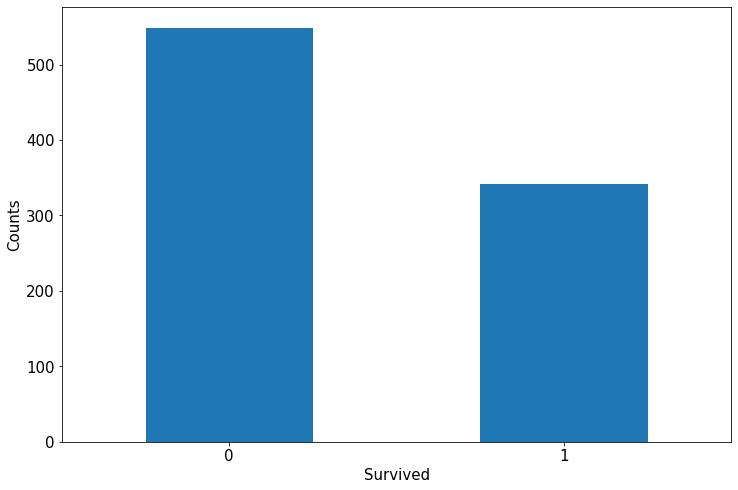

In [9]:
ax = dftrain_raw['Survived'].value_counts().plot(kind='bar',figsize=(12,8),fontsize=15,rot=0)
ax.set_ylabel('Counts',fontsize=15)
ax.set_xlabel('Survived',fontsize=15)
plt.show()

年龄分布情况

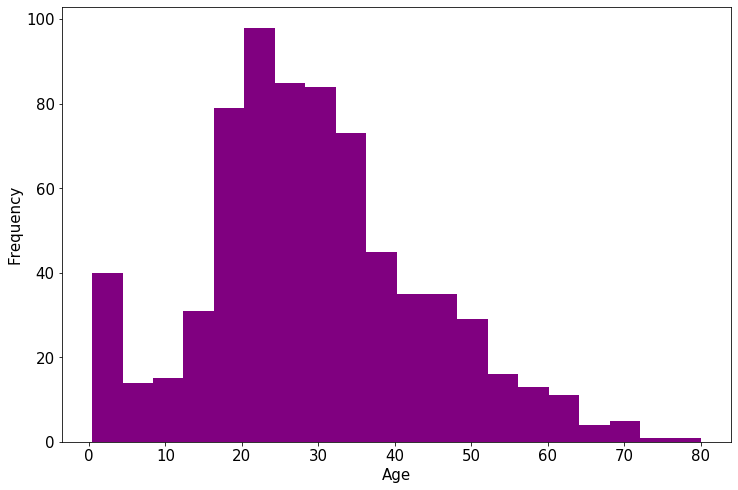

In [10]:
ax = dftrain_raw['Age'].plot(kind='hist',bins=20,color='purple',figsize=(12,8),fontsize=15)
ax.set_ylabel('Frequency',fontsize=15)
ax.set_xlabel('Age',fontsize=15)
plt.show()

年龄和label的相关性

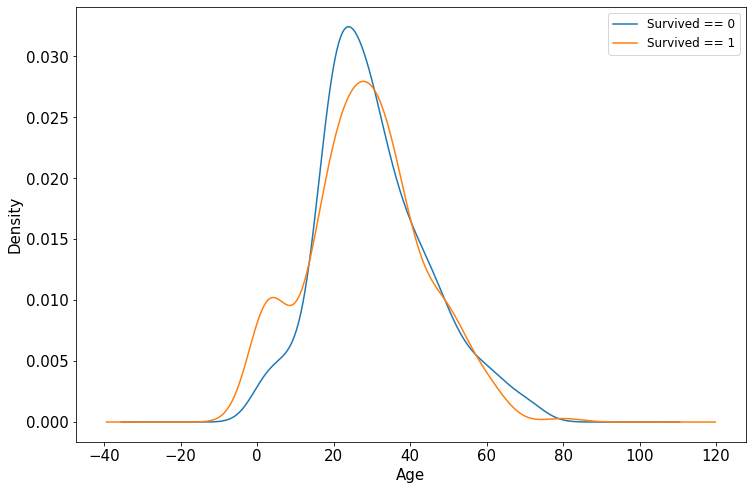

In [11]:
ax = dftrain_raw.query('Survived == 0')['Age'].plot(kind='density',figsize=(12,8),fontsize=15)
dftrain_raw.query('Survived == 1')['Age'].plot(kind='density',figsize=(12,8),fontsize=15)
ax.legend(['Survived == 0','Survived == 1'],fontsize=12)
ax.set_ylabel('Density',fontsize=15)
ax.set_xlabel('Age',fontsize=15)
plt.show()

下面为正式的数据预处理

In [12]:
def preprocessing(dfdata):
    dfresult = pd.DataFrame()

    #Pclass
    dfPclass = pd.get_dummies(dfdata['Pclass'])
    dfPclass.columns = ['Pclass_' + str(x) for x in dfPclass.columns]
    dfresult = pd.concat([dfresult,dfPclass],axis=1)

    #Sex
    dfSex = pd.get_dummies(dfdata['Sex'])
    dfresult = pd.concat([dfresult,dfSex],axis=1)

    #Age
    dfresult['Age'] = dfdata['Age'].fillna(0)
    dfresult['Age_null'] = pd.isna(dfdata['Age']).astype('int32')

    #SibSp,Parch,Fare
    dfresult['SibSp'] = dfdata['SibSp']
    dfresult['Parch'] = dfdata['Parch']
    dfresult['Fare'] = dfdata['Fare']

    #Carbin
    dfresult['Cabin_null'] = pd.isna(dfdata['Cabin']).astype('int32')

    #Embarked
    dfEmbarked = pd.get_dummies(dfdata['Embarked'],dummy_na=True)
    dfEmbarked.columns = ['Embarked_' + str(x) for x in dfEmbarked.columns]
    dfresult = pd.concat([dfresult,dfEmbarked],axis = 1)

    return(dfresult)

x_train = preprocessing(dftrain_raw)
y_train = dftrain_raw['Survived'].values

x_test = preprocessing(dftest_raw)
y_test = dftest_raw['Survived'].values

print("x_train.shape =", x_train.shape )
print("x_test.shape =", x_test.shape )

x_train.shape = (891, 15)
x_test.shape = (418, 15)


## 二，定义模型
使用Keras接口有以下3种方式构建模型：使用Sequential按层顺序构建模型，使用函数式API构建任意结构模型，继承Model基类构建自定义模型。

此处选择使用最简单的Sequential，按层顺序模型。

In [13]:
tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Dense(20,activation='relu',input_shape=(15,)))
model.add(layers.Dense(10,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________


## 三，训练模型
训练模型通常有3种方法，内置fit方法，内置train_on_batch方法，以及自定义训练循环。此处我们选择最常用也最简单的内置fit方法。

In [15]:
# 二分类问题选择二元交叉熵损失函数
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['AUC'])

history = model.fit(x_train,y_train,
                    batch_size=64,
                    epochs=30,
                    validation_split=0.2 #分割一部分训练数据用于验证
                    )

Train on 712 samples, validate on 179 samples
Epoch 1/30
712/712 [==============================] - 8s 11ms/sample - loss: 1.0857 - AUC: 0.4797 - val_loss: 0.7235 - val_AUC: 0.5397
Epoch 2/30
712/712 [==============================] - 0s 198us/sample - loss: 0.6924 - AUC: 0.5738 - val_loss: 0.5748 - val_AUC: 0.7149
Epoch 3/30
712/712 [==============================] - 0s 469us/sample - loss: 0.6605 - AUC: 0.6499 - val_loss: 0.5660 - val_AUC: 0.7249
Epoch 4/30
712/712 [==============================] - 0s 376us/sample - loss: 0.6334 - AUC: 0.6541 - val_loss: 0.5741 - val_AUC: 0.7287
Epoch 5/30
712/712 [==============================] - 0s 399us/sample - loss: 0.6222 - AUC: 0.6773 - val_loss: 0.5579 - val_AUC: 0.7555
Epoch 6/30
712/712 [==============================] - 0s 279us/sample - loss: 0.6163 - AUC: 0.6912 - val_loss: 0.5433 - val_AUC: 0.7643
Epoch 7/30
712/712 [==============================] - 0s 310us/sample - loss: 0.6138 - AUC: 0.7039 - val_loss: 0.5361 - val_AUC: 0.7777
Epo

## 四，评估模型
我们首先评估一下模型在训练集和验证集上的效果。

In [16]:
import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

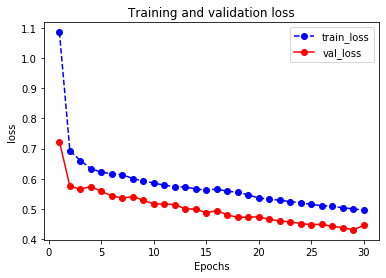

In [17]:
plot_metric(history,'loss')

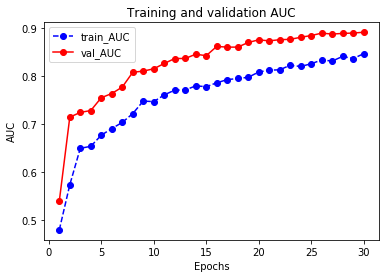

In [18]:
plot_metric(history,'AUC')

我们再看一下模型在测试集上的效果.

In [19]:
model.evaluate(x=x_test,y=y_test)

418/418 [==============================] - 0s 390us/sample - loss: 0.4921 - AUC: 0.8551


[0.4921088627936167, 0.85512286]

## 五，使用模型

In [20]:
#预测概率
model.predict(x_test[0:10])

array([[0.18326738],
       [0.2832925 ],
       [0.19782548],
       [0.1762601 ],
       [0.37330964],
       [0.19557685],
       [0.38116488],
       [0.32055578],
       [0.48437312],
       [0.1442889 ]], dtype=float32)

In [21]:
#预测类别
model.predict_classes(x_test[0:10])

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

## 六，保存模型
可以使用Keras方式保存模型，也可以使用TensorFlow原生方式保存。前者仅仅适合使用Python环境恢复模型，后者则可以跨平台进行模型部署。

推荐使用后一种方式进行保存。

1.Keras方式保存

In [22]:
# 保存模型结构及权重

model.save('keras_model.h5')  

del model  #删除现有模型

# identical to the previous one
model = models.load_model('keras_model.h5')
model.evaluate(x_test,y_test)

418/418 [==============================] - 0s 856us/sample - loss: 0.4921 - AUC: 0.8551


[0.4921088627936167, 0.85512286]

In [23]:
# 保存模型结构
json_str = model.to_json()

# 恢复模型结构
model_json = models.model_from_json(json_str)

In [24]:
#保存模型权重
model.save_weights('keras_model_weight.h5')

# 恢复模型结构
model_json = models.model_from_json(json_str)
model_json.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['AUC']
    )

# 加载权重
model_json.load_weights('keras_model_weight.h5')
model_json.evaluate(x_test,y_test)

418/418 [==============================] - 1s 1ms/sample - loss: 0.4921 - AUC: 0.8551


[0.4921088627936167, 0.85512286]

2，TensorFlow原生方式保存

In [25]:
# 保存权重，该方式仅仅保存权重张量
model.save_weights('tf_model_weights.ckpt',save_format = "tf")

In [ ]:
# 保存模型结构与模型参数到文件,该方式保存的模型具有跨平台性便于部署

model.save('tf_model_savedmodel', save_format="tf")
print('export saved model.')

model_loaded = tf.keras.models.load_model('tf_model_savedmodel')
model_loaded.evaluate(x_test,y_test)